In [2]:
%matplotlib inline

import os
import sys
import datacube
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rasterio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from datacube.storage.masking import make_mask
from datacube.storage.masking import mask_invalid_data

sys.path.append("Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser
from dea_plotting import rgb
from dea_datahandling import load_ard
from dea_datahandling import dilate
from dea_bandindices import calculate_indices

sys.path.append("..")
from multipolyfit import multipolyfit

In [3]:
dc = datacube.Datacube(app="Regression_test")

In [4]:
# setting some appropriate variables

lat = (-34,-34.5)
lon = (145,145.5)
time = ("2015-01-25","2015-05-22")

In [5]:
# querying for some data to test the regression against

query = {'x':lon,
        'y':lat,
        'time':time,
        'output_crs':'EPSG:3577',
        'resolution':(-25,25),
        'measurements':['nbart_swir_1','nbart_red','nbart_blue','nbart_green','nbart_swir_2','nbart_panchromatic','nbart_nir','fmask'],
        'group_by':'solar_day',
         'resampling':{'fmask': 'nearest', '*': 'average'}
        }
regress = dc.load(product='ga_ls8c_ard_3',**query)

In [6]:
# NDVI indexing for use in the regreswsion comparison

regress['NDVI'] = (regress.nbart_nir-regress.nbart_red)/(regress.nbart_nir+regress.nbart_red)

In [7]:
# normalising the swir_1 (band 6) as an index relative to its maximum and minimum
swir_1_max = regress.nbart_swir_1.max()
swir_1_min = regress.nbart_swir_1.min()

regress["NSWIR"] = (regress.nbart_swir_1-swir_1_min)/(swir_1_max-swir_1_min)

In [8]:
# creating the constants for the analysis
c1 = 1.19104356*10**(-16)
c2 = 1.43876869*10**(-2)
wlen = 1.61*10**(-6)
K1 = c1/(wlen**5)
K2 = c2/wlen

regress["t_bright"] = K2/np.log((K1/regress.NSWIR)+1)-273.15

In [9]:
# creating the fractional cover index

regress["frac_cov"] = ((regress.NDVI-regress.NDVI.min())/(regress.NDVI.max()-regress.NDVI.min()))**2

In [10]:
# emissivity calculations
regress["emis"] = 0.986-(0.986-0.928)*regress.frac_cov

In [11]:
# land surface temperature calculation

regress["lst"] = (regress.t_bright)/(1+((wlen*regress.t_bright)/c2)*np.log(regress.emis))

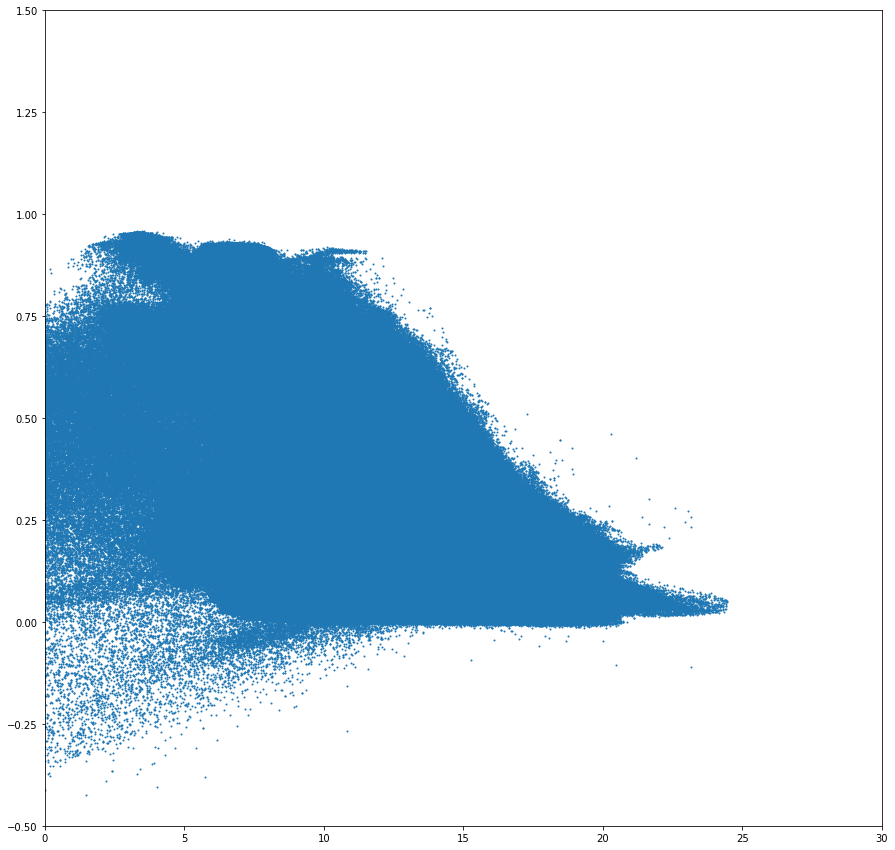

In [11]:
y_axis = regress.NDVI
x_axis = regress.lst

plt.figure(figsize=(15,15))
plt.scatter(x_axis,y_axis,s=1)
plt.ylim(-0.5,1.5)
plt.xlim(0,30)
plt.show()

In [12]:
regress["NDVI_n"] = (regress.NDVI.max()-regress.NDVI)/(regress.NDVI.max()-regress.NDVI.min())

In [13]:
regress['Ts_n'] = (regress.lst.max()-regress.lst)/(regress.lst.max()-regress.lst.min())

In [14]:
# converting the surface temperature and NDVI normalised values into a numpy array rather than an xarray

NDVI_stat_np = regress.NDVI_n.values
Ts_stat_np = regress.Ts_n.values

# now setting up the arrays so that they are just vectors for the first

Ts_vect = []
NDVI_vect = []
NDVI_overall = []
Ts_overall = []
for t in range(0,NDVI_stat_np.shape[0]):
    for i in range(0,NDVI_stat_np.shape[1]):
        for j in range(0,NDVI_stat_np.shape[2]):
            a = NDVI_stat_np[t,i,j]
            b = Ts_stat_np[t,i,j]
            NDVI_vect.append(a)
            Ts_vect.append(b)
    NDVI_overall.append(NDVI_vect)
    Ts_overall.append(Ts_vect)
    NDVI_vect = []
    Ts_vect = []

In [15]:
# setting up the bivariate statistics for analysis

bivariate_data = (NDVI_overall[0],Ts_overall[0])
biv = np.asarray(bivariate_data)

In [16]:
Soil_m = np.random.rand(len(NDVI_overall[0]))
Soil_m

array([0.88269366, 0.80152985, 0.97007175, ..., 0.87830601, 0.39207252,
       0.28406989])

In [1]:
# multipolyfit.multipolyfit(biv,Soil_m,deg=2)

NameError: name 'multipolyfit' is not defined

In [17]:
predict = np.random.rand(2)

In [18]:
poly_mod = PolynomialFeatures(degree=2)

In [20]:
biv_ = poly_mod.fit_transform(biv)

KeyboardInterrupt: 

In [ ]:
pred_ = poly_mod.fit_transform(predict)

In [ ]:
clf = linear_model.LinearRegression()
clf.fit(biv_,Soil_m)

In [ ]:
plot.scatter()